# Analyzing the embeddings

This notebook pretends to analyze the output of the get_embeddings script evaluating them with a dataset

In [1]:
# Library imports
import os
import glob

import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sentence_transformers import util

In [2]:
# Global variables
MODELS = ['all-MiniLM-L6-v2', 'multi-qa-mpnet-base-dot-v1', 'Qwen/Qwen3-Embedding-0.6B', 'Qwen/Qwen3-Embedding-4B', 'Qwen/Qwen3-Embedding-8B', 'Qwen3-Embedding-0.6B-Q8_0', 'Qwen3-Embedding-0.6B-f16', 'Qwen3-Embedding-4B-Q4_K_M', 'Qwen3-Embedding-4B-f16', 'Qwen3-Embedding-8B-Q4_K_M', 'Qwen3-Embedding-8B-f16']
DATA_PATH = '../data'
DATA_EMBEDDINGS_PATH = f'../data_embeddings'
DATASET_EMBEDDINGS_PATH = f'../dataset_embeddings'
DATASET_NAME = 'Rivert97/ug-normativity'
RESULTS_DIR = '../results'

# Other variables
k = 5
file_excludes = ['reglamento-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato']

In [3]:
def load_csv_data(data_embeddings_dirname, dataset_embeddings_dirname):
    all_data = []
    all_embeddings = []
    all_questions_embeddings = []

    # Loading the data
    for data_filename in glob.glob(os.path.join(DATA_PATH, '*.csv')):
        embeddings_filename = os.path.join(data_embeddings_dirname, os.path.split(data_filename)[1])
        questions_filename = os.path.join(dataset_embeddings_dirname, os.path.split(data_filename)[1])

        if not os.path.exists(questions_filename):
            print(f"Ignoring file {data_filename}")
            file_excludes.append(os.path.splitext(os.path.split(data_filename)[1])[0])
            continue

        data = pd.read_csv(data_filename, sep=',')
        embeddings = pd.read_csv(embeddings_filename, sep=',', index_col=0)
        questions_embeddings = pd.read_csv(questions_filename, sep=',', index_col=0)

        all_data.append(data)
        all_embeddings.append(embeddings)
        all_questions_embeddings.append(questions_embeddings)

    data = pd.concat(all_data, ignore_index=True)
    embeddings = pd.concat(all_embeddings, ignore_index=True)
    questions_embeddings = pd.concat(all_questions_embeddings)

    return data, embeddings, questions_embeddings

In [4]:
def find_questions_related_chunks(dataset, questions_embeddings, data, embeddings):
    # For each question find its chunk
    questions = []

    for question in dataset:
        if question['title'] in file_excludes:
            continue

        tmp_question = {
            'question': question,
            'question_embeddings': questions_embeddings.loc[question['id']].values,
            'chunk_idx': None,
            'chunk': None,
            'chunk_embeddings': None,
        }

        for chunk_idx, chunk in data.loc[data['document_name'] == question['title']].iterrows():
            if chunk['path'].lower().endswith(question['context'].lower().strip()):
                tmp_question['chunk_idx'] = chunk_idx
                tmp_question['chunk'] = chunk
                tmp_question['chunk_embeddings'] = embeddings.loc[chunk_idx].values
                break

        if tmp_question['chunk_idx'] is not None:
            questions.append(tmp_question)

    return questions

In [5]:
def get_scores_from_questions_to_answers(questions):
    # Analyzing scores between questions and its chunks
    scores = []
    for question in questions:
        score = util.dot_score(question['question_embeddings'], question['chunk_embeddings'])
        scores.append(score[0][0])

    return scores

In [6]:
def get_top_k_scores_info(questions, data, embeddings):
    # Analyzing score from each question to its K neighbors
    top_k_info = {
        'scores': [],
        'scores_mean': [],
        'embeddings_idx': {},
    }
    for question in questions:
        scores = util.dot_score(question['question_embeddings'], embeddings.values)[0].tolist()
        doc_score_pairs = list(zip(data.index.tolist(), scores))

        doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

        dist = [d[1] for d in doc_score_pairs[:k]]
        idx = [d[0] for d in doc_score_pairs[:k]]

        top_k_info['scores'].extend(dist)
        top_k_info['scores_mean'].append(np.mean(dist))
        top_k_info['embeddings_idx'][question['question']['id']] = idx

    return top_k_info

In [7]:
def get_presence_percentage_in_top_k(questions, top_k_info):
    # Analyzing percentaje of answers present in K nearest neighbors
    count_in_top_k = 0
    for question in questions:
        top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
        if question['chunk_idx'] in top_k_idx:
            count_in_top_k += 1

    presence_top_k = count_in_top_k/len(questions)

    return presence_top_k

In [8]:
def get_f1_metrics_at_k(questions, data, top_k_info):
    # Obtaining F1@k
    metrics = {
        'precisions': np.zeros((len(questions),), dtype=np.float32),
        'recalls': np.zeros((len(questions),), dtype=np.float32),
        'f1s': np.zeros((len(questions),), dtype=np.float32),
    }

    for q_idx, question in enumerate(questions):
        n_relevant = 0
        top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
        all_relevant = data[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

        for idx in top_k_idx:
            if data.loc[idx, 'path'].lower().endswith(question['question']['context'].lower()):
                n_relevant += 1

        precision = n_relevant/k
        recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
        f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

        metrics['precisions'][q_idx] = precision
        metrics['recalls'][q_idx] = recall
        metrics['f1s'][q_idx] = f1

    return metrics['precisions'].mean(), metrics['recalls'].mean(), metrics['f1s'].mean()

In [9]:
def update_csv_data(filename, new_data, axis=0):
    if os.path.exists(filename):
        prev_df = pd.read_csv(filename, sep=',', index_col=0)
        if axis == 0:
            if set(new_data.index).intersection(set(prev_df.index)):
                for idx in new_data.index:
                    prev_df.loc[idx] = new_data.loc[idx]
                updated_df = prev_df
            else:
                updated_df = pd.concat([prev_df, new_data], ignore_index=False, axis=axis)
        else:
            if set(new_data.columns).intersection(set(prev_df.columns)):
                for col in new_data.columns:
                    prev_df[col] = new_data[col]
                updated_df = prev_df
            else:
                updated_df = pd.concat([prev_df, new_data], ignore_index=False, axis=axis)
    else:
        updated_df = new_data

    updated_df.to_csv(filename, sep=',')

In [10]:
def get_presence_percentage_in_top_k_by_file(questions, top_k_info, document_list, model_id):
    # Analyzing percentaje of answers present in K nearest neighbors
    presence_top_k = []
    for file in document_list:
        if file in file_excludes:
            continue

        count_in_top_k = 0
        total_count = 0
        for question in filter(lambda q: q['question']['title'] == file, questions):
            top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
            if question['chunk_idx'] in top_k_idx:
                count_in_top_k += 1
            total_count += 1

        presence = count_in_top_k/total_count
        presence_top_k.append(presence)

    return pd.DataFrame({model_id: presence_top_k}, index=document_list)

In [11]:
def get_f1_metrics_at_k_by_file(questions, data, top_k_info, document_list, model_id):
    # Obtaining F1@k
    mean_precisions = []
    mean_recalls = []
    mean_f1s = []
    for file in document_list:
        if file in file_excludes:
            continue

        file_questions = list(filter(lambda q: q['question']['title'] == file, questions))

        metrics = {
            'precisions': np.zeros((len(file_questions),), dtype=np.float32),
            'recalls': np.zeros((len(file_questions),), dtype=np.float32),
            'f1s': np.zeros((len(file_questions),), dtype=np.float32),
        }
        for q_idx, question in enumerate(file_questions):
            n_relevant = 0
            top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
            all_relevant = data.loc[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

            for idx in top_k_idx:
                chunk = data.loc[idx]
                if (chunk['document_name'] == question['question']['title'] and
                    chunk['path'].lower().endswith(question['question']['context'].lower())):
                    n_relevant += 1

            precision = n_relevant/k
            recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
            f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

            metrics['precisions'][q_idx] = precision
            metrics['recalls'][q_idx] = recall
            metrics['f1s'][q_idx] = f1

        mean_precision = metrics['precisions'].mean()
        mean_recall = metrics['recalls'].mean()
        mean_f1 = metrics['f1s'].mean()

        mean_precisions.append(mean_precision)
        mean_recalls.append(mean_recall)
        mean_f1s.append(mean_f1)

    return pd.DataFrame({f'{model_id} precision': mean_precisions, f'{model_id} recall': mean_recalls, f'{model_id} f1': mean_f1s}, index=document_list)

In [12]:
# Loading questions dataset
dataset = load_dataset(DATASET_NAME)
dataset = dataset['train']

In [13]:
dataset

Dataset({
    features: ['id', 'title', 'context', 'additional_context', 'question', 'answers'],
    num_rows: 1836
})

In [14]:
all_models_scores = {}
all_models_top_k_info = {}
all_models_full_metrics = []
all_models_presence_by_file = []
all_models_metrics_by_file = []
for model_id in MODELS:
    print(f"Procesando {model_id}")
    data, embeddings, questions_embeddings = load_csv_data(os.path.join(DATA_EMBEDDINGS_PATH, model_id), os.path.join(DATASET_EMBEDDINGS_PATH, model_id))
    questions = find_questions_related_chunks(dataset, questions_embeddings, data, embeddings)
    scores = get_scores_from_questions_to_answers(questions)
    top_k_info = get_top_k_scores_info(questions, data, embeddings)
    presence = get_presence_percentage_in_top_k(questions, top_k_info)
    precision, recall, f1 = get_f1_metrics_at_k(questions, data, top_k_info)

    full_metrics = pd.DataFrame({'% presence': [presence], 'precision': [precision], 'recall': [recall], 'f1': [f1]}, index=[model_id])
    full_metrics_filename = os.path.join(RESULTS_DIR, f'mean_metrics_top_{k}.csv')
    update_csv_data(full_metrics_filename, full_metrics)

    presence_by_file = get_presence_percentage_in_top_k_by_file(questions, top_k_info, data['document_name'].unique(), model_id)

    presence_by_file_filename = os.path.join(RESULTS_DIR, f'presence_top_{k}.csv')
    update_csv_data(presence_by_file_filename, presence_by_file, axis=1)

    metrics_by_file = get_f1_metrics_at_k_by_file(questions, data, top_k_info, data['document_name'].unique(), model_id)

    metrics_by_file_filename = os.path.join(RESULTS_DIR, f'metrics_top_{k}.csv')
    update_csv_data(metrics_by_file_filename, metrics_by_file, axis=1)

    all_models_scores[model_id] = scores
    all_models_top_k_info[model_id] = top_k_info
    all_models_full_metrics.append(full_metrics)
    all_models_presence_by_file.append(presence_by_file)
    all_models_metrics_by_file.append(metrics_by_file)

Procesando all-MiniLM-L6-v2
Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv
Ignoring file ../data/reglameto-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato.csv
Procesando multi-qa-mpnet-base-dot-v1
Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv
Ignoring file ../data/reglameto-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato.csv
Procesando Qwen/Qwen3-Embedding-0.6B
Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv
Ignoring file ../data/reglameto-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato.csv
Procesando Qwen/Qwen3-Embedding-4B
Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv
Ignoring file ../data/reglameto-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuat

all-MiniLM-L6-v2
Scores top-5
Min:  0.4286460816694121
Max:  0.9139088910045836
Mean:  0.6737094427829318
Scores top-5 mean
Min:  0.4777138140220495
Max:  0.8507478635000483
Mean:  0.6737094427829318

multi-qa-mpnet-base-dot-v1
Scores top-5
Min:  18.913070757930512
Max:  36.34816770899501
Mean:  27.643243715650424
Scores top-5 mean
Min:  20.311917010501368
Max:  33.46086238900649
Mean:  27.643243715650424

Qwen/Qwen3-Embedding-0.6B
Scores top-5
Min:  0.2761518528980393
Max:  0.9228972905022448
Mean:  0.5863665771430818
Scores top-5 mean
Min:  0.3335493332443542
Max:  0.8429893576680956
Mean:  0.5863665771430819

Qwen/Qwen3-Embedding-4B
Scores top-5
Min:  0.2646974137284473
Max:  0.9260228605678094
Mean:  0.5848312148321265
Scores top-5 mean
Min:  0.33808126713315795
Max:  0.8387559859951164
Mean:  0.5848312148321265

Qwen/Qwen3-Embedding-8B
Scores top-5
Min:  0.30708593752322955
Max:  0.9389169842746895
Mean:  0.6031938789932111
Scores top-5 mean
Min:  0.35981952768950565
Max:  0.85876

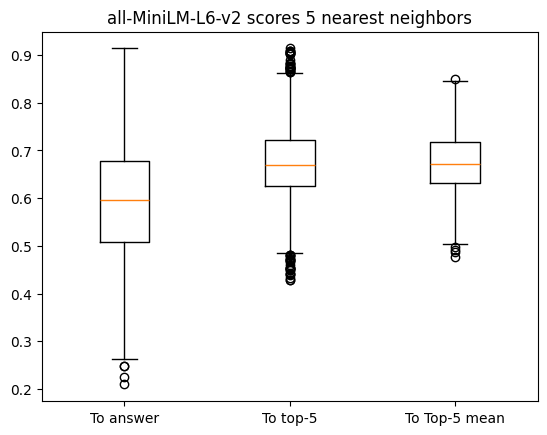

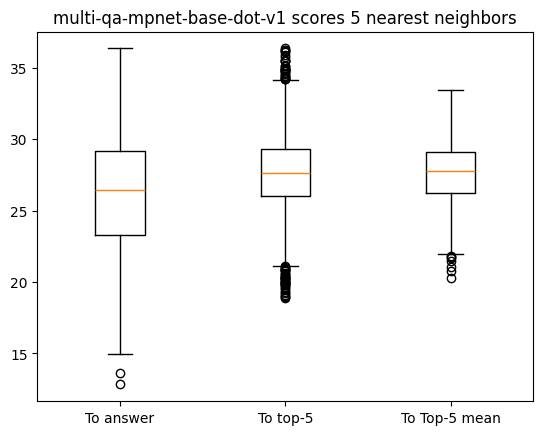

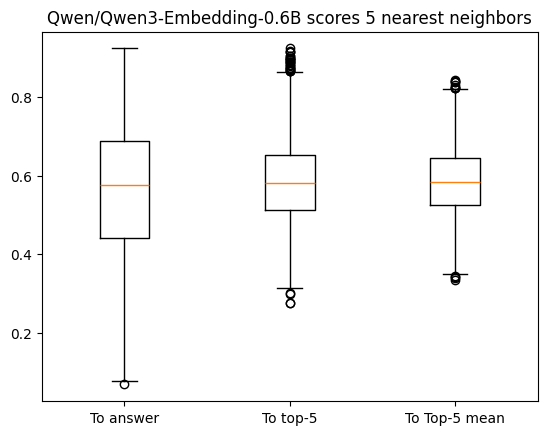

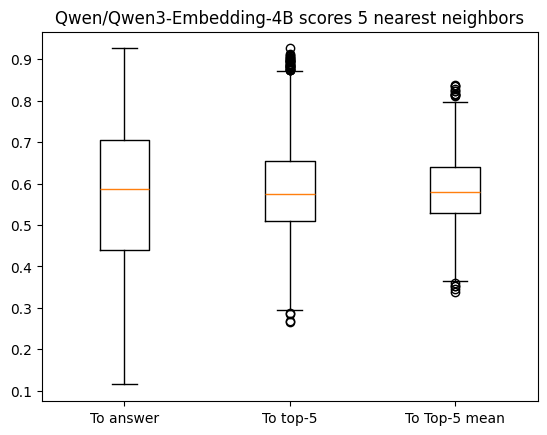

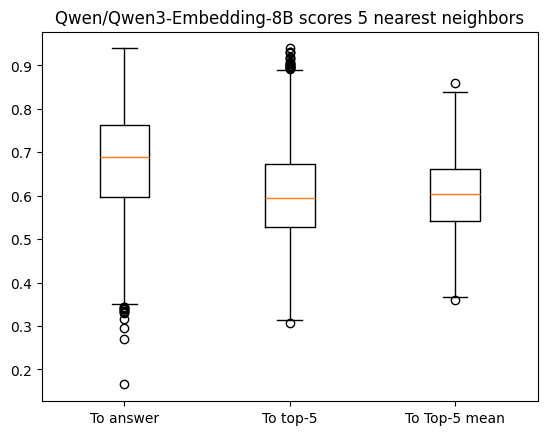

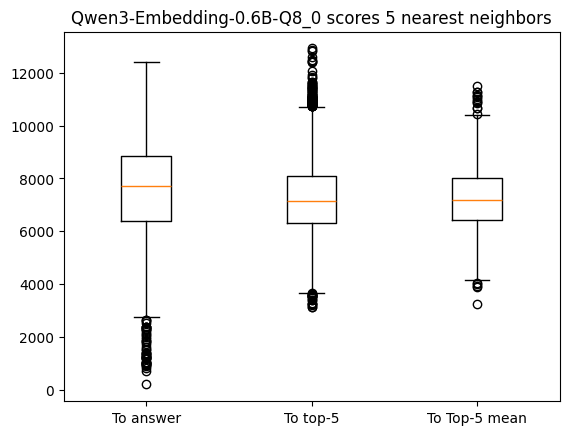

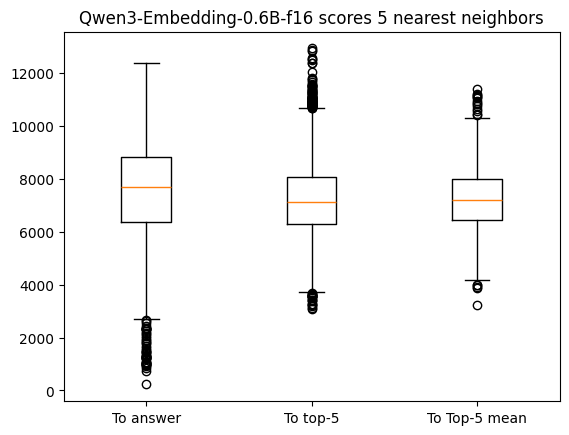

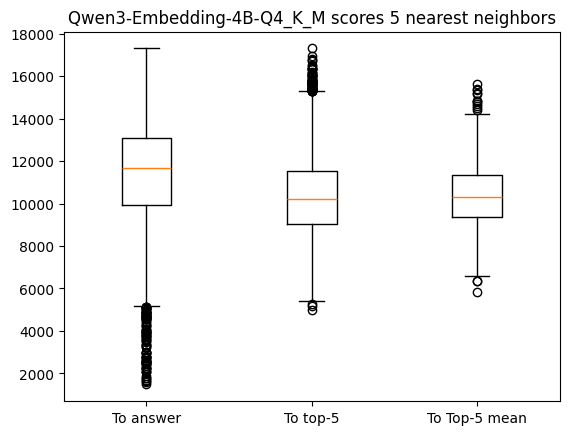

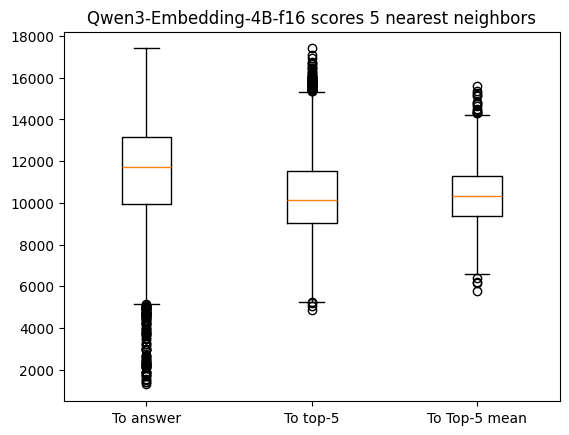

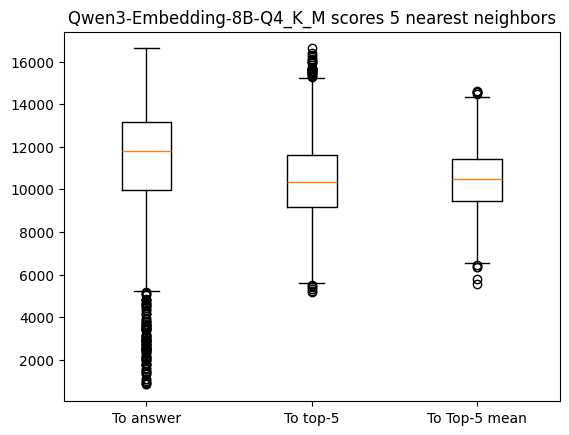

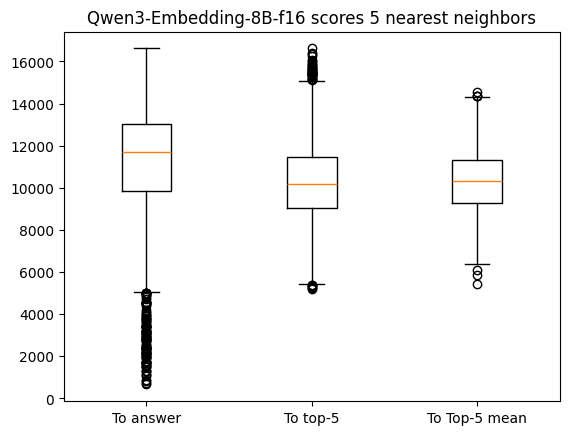

In [17]:
save_img_dir = os.path.join(RESULTS_DIR, 'images', f'top_{k}')
os.makedirs(save_img_dir, exist_ok=True)

for model_id in MODELS:
    plt.figure()
    plt.title(f"{model_id} scores {k} nearest neighbors")
    plt.boxplot((all_models_scores[model_id], all_models_top_k_info[model_id]['scores'], all_models_top_k_info[model_id]['scores_mean']), tick_labels=['To answer', f'To top-{k}', f'To Top-{k} mean'])
    plt.savefig(os.path.join(save_img_dir, f'{model_id.split('/')[-1]}.png'))
    print(model_id)
    print(f"Scores top-{k}")
    print("Min: ", min(all_models_top_k_info[model_id]['scores']))
    print("Max: ", max(all_models_top_k_info[model_id]['scores']))
    print("Mean: ", np.mean(all_models_top_k_info[model_id]['scores']))
    print(f"Scores top-{k} mean")
    print("Min: ", min(all_models_top_k_info[model_id]['scores_mean']))
    print("Max: ", max(all_models_top_k_info[model_id]['scores_mean']))
    print("Mean: ", np.mean(all_models_top_k_info[model_id]['scores_mean']))
    print('')

In [ ]:
final_full_metrics = pd.concat(all_models_full_metrics)
final_full_metrics

,% presence,precision,recall,f1
all-MiniLM-L6-v2,0.246027,0.091333,0.273999,0.136999
multi-qa-mpnet-base-dot-v1,0.380165,0.133927,0.400826,0.200509
Qwen/Qwen3-Embedding-0.6B,0.526383,0.184149,0.549587,0.274889
Qwen/Qwen3-Embedding-4B,0.556898,0.195804,0.584552,0.292371
Qwen/Qwen3-Embedding-8B,0.876033,0.304514,0.909409,0.454800
Qwen3-Embedding-0.6B-Q8_0,0.707565,0.247298,0.738080,0.369040
Qwen3-Embedding-0.6B-f16,0.712015,0.248782,0.743166,0.371583
Qwen3-Embedding-4B-Q4_K_M,0.809282,0.283535,0.843929,0.422060
Qwen3-Embedding-4B-f16,0.808010,0.282475,0.841386,0.420788
Qwen3-Embedding-8B-Q4_K_M,0.814367,0.285866,0.852511,0.426446


In [ ]:
final_presence_by_file = pd.concat(all_models_presence_by_file, ignore_index=False, axis=1)
final_presence_by_file

,all-MiniLM-L6-v2,multi-qa-mpnet-base-dot-v1,Qwen/Qwen3-Embedding-0.6B,Qwen/Qwen3-Embedding-4B,Qwen/Qwen3-Embedding-8B,Qwen3-Embedding-0.6B-Q8_0,Qwen3-Embedding-0.6B-f16,Qwen3-Embedding-4B-Q4_K_M,Qwen3-Embedding-4B-f16,Qwen3-Embedding-8B-Q4_K_M,Qwen3-Embedding-8B-f16
ley-organica-de-la-universidad-de-guanajuato,0.359649,0.526316,0.763158,0.842105,0.824561,0.631579,0.649123,0.789474,0.807018,0.798246,0.771930
reglamento-del-personal-academico-de-la-universidad-de-guanajuato,0.316832,0.534653,0.831683,0.905941,0.910891,0.707921,0.712871,0.831683,0.826733,0.831683,0.836634
reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato,0.603774,0.773585,0.905660,0.981132,0.981132,0.792453,0.792453,0.905660,0.924528,0.905660,0.924528
reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato,0.530303,0.727273,0.909091,0.924242,0.939394,0.863636,0.848485,0.939394,0.939394,0.954545,0.954545
reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato,0.434783,0.669565,0.886957,0.921739,0.904348,0.852174,0.869565,0.913043,0.913043,0.921739,0.930435
reglamento-interno-del-patronato-de-la-universidad-de-guanajuato,0.303030,0.484848,0.787879,0.727273,0.757576,0.696970,0.696970,0.727273,0.696970,0.757576,0.757576
reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023,0.276596,0.468085,0.787234,0.765957,0.765957,0.531915,0.510638,0.659574,0.638298,0.702128,0.702128
reglamento-academico-de-la-universidad-de-guanajuato,0.454545,0.757576,0.929293,0.959596,0.959596,0.838384,0.848485,0.878788,0.878788,0.898990,0.898990
codigo-de-etica-de-las-personas-servidoras-publicas-universidad-de-gunajuato,0.272727,0.363636,0.500000,0.818182,0.909091,0.272727,0.272727,0.409091,0.409091,0.454545,0.454545
reglamento-de-la-defensoria-de_los-derechos-humanos-en-el-entorno-universitario-de-la-universidad-de-guanajuato,0.313953,0.569767,0.837209,0.883721,0.895349,0.837209,0.837209,0.872093,0.883721,0.883721,0.895349


In [ ]:
final_metrics_by_file = pd.concat(all_models_metrics_by_file, ignore_index=False, axis=1)
final_metrics_by_file

,all-MiniLM-L6-v2 precision,all-MiniLM-L6-v2 recall,all-MiniLM-L6-v2 f1,multi-qa-mpnet-base-dot-v1 precision,multi-qa-mpnet-base-dot-v1 recall,multi-qa-mpnet-base-dot-v1 f1,Qwen/Qwen3-Embedding-0.6B precision,Qwen/Qwen3-Embedding-0.6B recall,Qwen/Qwen3-Embedding-0.6B f1,Qwen/Qwen3-Embedding-4B precision,...,Qwen3-Embedding-4B-Q4_K_M f1,Qwen3-Embedding-4B-f16 precision,Qwen3-Embedding-4B-f16 recall,Qwen3-Embedding-4B-f16 f1,Qwen3-Embedding-8B-Q4_K_M precision,Qwen3-Embedding-8B-Q4_K_M recall,Qwen3-Embedding-8B-Q4_K_M f1,Qwen3-Embedding-8B-f16 precision,Qwen3-Embedding-8B-f16 recall,Qwen3-Embedding-8B-f16 f1
ley-organica-de-la-universidad-de-guanajuato,0.119883,0.359649,0.179825,0.175439,0.526316,0.263158,0.254386,0.763158,0.381579,0.280702,...,0.394737,0.269006,0.807018,0.403509,0.266082,0.798246,0.399123,0.257310,0.771930,0.385965
reglamento-del-personal-academico-de-la-universidad-de-guanajuato,0.105611,0.316832,0.158416,0.178218,0.534653,0.267327,0.277228,0.831683,0.415842,0.301980,...,0.415842,0.275578,0.826733,0.413366,0.277228,0.831683,0.415842,0.278878,0.836634,0.418317
reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato,0.201258,0.603774,0.301887,0.257862,0.773585,0.386792,0.301887,0.905660,0.452830,0.327044,...,0.452830,0.308176,0.924528,0.462264,0.301887,0.905660,0.452830,0.308176,0.924528,0.462264
reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato,0.176768,0.530303,0.265152,0.242424,0.727273,0.363636,0.303030,0.909091,0.454545,0.308081,...,0.469697,0.313131,0.939394,0.469697,0.318182,0.954545,0.477273,0.318182,0.954545,0.477273
reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato,0.142029,0.426087,0.213043,0.220290,0.660870,0.330435,0.292754,0.869565,0.434783,0.304348,...,0.452174,0.301449,0.904348,0.452174,0.304348,0.904348,0.452174,0.307246,0.913043,0.456522
reglamento-interno-del-patronato-de-la-universidad-de-guanajuato,0.101010,0.303030,0.151515,0.171717,0.500000,0.254545,0.272727,0.803030,0.406061,0.252525,...,0.375758,0.242424,0.712121,0.360606,0.272727,0.787879,0.403030,0.262626,0.772727,0.390909
reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023,0.092199,0.276596,0.138298,0.156028,0.468085,0.234043,0.262411,0.787234,0.393617,0.255319,...,0.329787,0.212766,0.638298,0.319149,0.234043,0.702128,0.351064,0.234043,0.702128,0.351064
reglamento-academico-de-la-universidad-de-guanajuato,0.151515,0.454545,0.227273,0.252525,0.757576,0.378788,0.309764,0.929293,0.464646,0.319865,...,0.439394,0.292929,0.878788,0.439394,0.299663,0.898990,0.449495,0.299663,0.898990,0.449495
codigo-de-etica-de-las-personas-servidoras-publicas-universidad-de-gunajuato,0.090909,0.272727,0.136364,0.121212,0.363636,0.181818,0.166667,0.500000,0.250000,0.272727,...,0.204545,0.136364,0.409091,0.204545,0.151515,0.454545,0.227273,0.151515,0.454545,0.227273
reglamento-de-la-defensoria-de_los-derechos-humanos-en-el-entorno-universitario-de-la-universidad-de-guanajuato,0.104651,0.313953,0.156977,0.189922,0.569767,0.284884,0.279070,0.837209,0.418605,0.294574,...,0.436047,0.294574,0.883721,0.441860,0.294574,0.883721,0.441860,0.298450,0.895349,0.447674
